In [1]:
from eumap.misc import find_files, nan_percentile, GoogleSheet, ttprint
from sklearn.metrics import r2_score, mean_squared_error
from tool_kit import calc_ccc, accuracy_plot, uncertainty_plot
from sklearn.model_selection import cross_val_score, KFold, GroupKFold
from mapie.regression import MapieRegressor

import pandas as pd
import numpy as np
import warnings
import joblib
warnings.filterwarnings('ignore')

# read in necessary material
folder = '/mnt/inca/soc_eu_model'
test = pd.read_csv(f'{folder}/data/004.0_validate.pnts_oc.csv',low_memory=False)
train = pd.read_csv(f'{folder}/data/005.0_train.pnts_oc.csv',low_memory=False)

# covariates
with open(f'{folder}/SOC-EU/features/002_selected.covar_rank.freq.txt', 'r') as file:
    lines = file.readlines()
covs = [line.strip() for line in lines]

# dataset
train = train.dropna(subset=covs,how='any')
test = test.dropna(subset=covs,how='any')

# target variable
tgt = 'oc_log1p'

# spatial cross validation
spatial_cv_column = 'tile_id'
cv = GroupKFold(n_splits=5)

/home/opengeohub/.local/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.3-CAPI-1.17.3) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


### spatial cross validation

[15:41:13] spatial CV for rf
[16:21:36] finish spatial cv


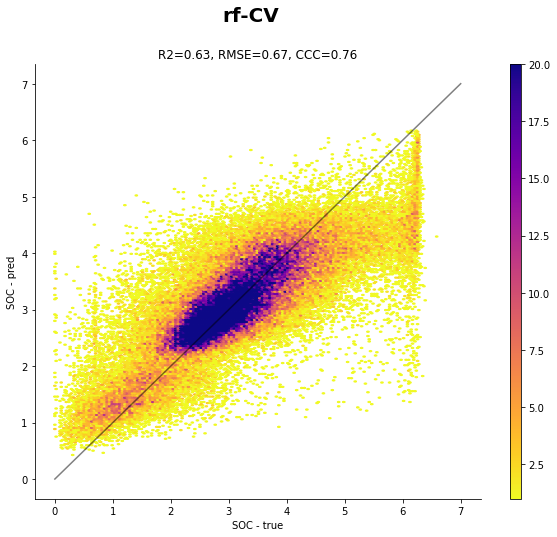

[16:21:37] spatial CV for lasso
[16:22:04] finish spatial cv


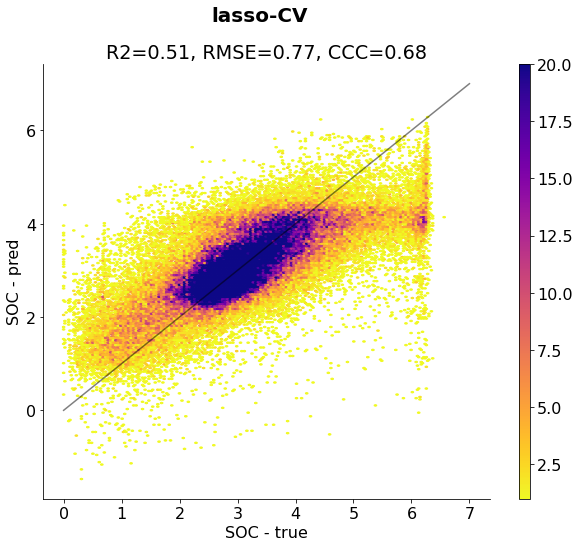

[16:22:05] spatial CV for ann
[16:22:48] finish spatial cv


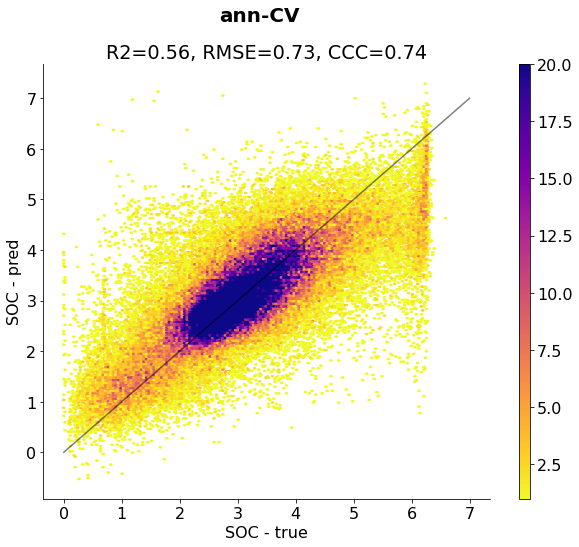

[16:22:49] spatial CV for cubist


/home/opengeohub/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.336e+04, tolerance: 9.715e+00
  model = cd_fast.enet_coordinate_descent(
/home/opengeohub/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.354e+04, tolerance: 9.711e+00
  model = cd_fast.enet_coordinate_descent(
/home/opengeohub/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

[16:42:18] finish spatial cv


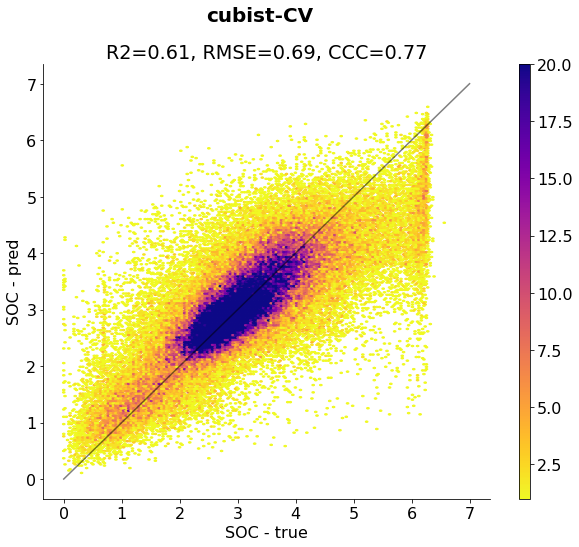

In [2]:
from sklearn.model_selection import cross_val_predict

# get all the trained models
model_list = find_files(f'{folder}/SOC-EU/model/','*model*')
model_list = [str(i) for i in model_list]

results = []

for model_path in model_list:
    model_name = model_path.split('_')[-1].split('.')[0]
    model = joblib.load(model_path)
    
    group_kfold = GroupKFold(n_splits=5)

    ttprint(f'spatial CV for {model_name}')
    y_pred_cv = cross_val_predict(model, train[covs], train[tgt], cv=group_kfold, groups=train[spatial_cv_column], n_jobs=90)
    ttprint(f'finish spatial cv')
    
    # calculate metrix, and visualize the results
    r2_cv, rmse_cv, ccc_cv = accuracy_plot(train[tgt], y_pred_cv, model_name + '-CV') # visuliazation

    # Store the results for the current feature set
    results.append({
        'title': model_name,
        'R2_CV': r2_cv,
        'RMSE_CV': rmse_cv,
        'CCC_CV': ccc_cv
    })

In [5]:
results_df = pd.DataFrame(results)
results_df.to_csv(f'{folder}/SOC-EU/model/009_metrics_cv.base.model.csv', index=False)
results_df 

,title,R2_CV,RMSE_CV,CCC_CV,R2_val,RMSE_val,CCC_val,PICP,PI width
0,rf,0.627016,0.673353,0.763142,NaN,NaN,NaN,NaN,NaN
1,lasso,0.509814,0.771931,0.677274,NaN,NaN,NaN,NaN,NaN
2,ann,0.559766,0.731542,0.742849,NaN,NaN,NaN,NaN,NaN
3,cubist,0.607866,0.690423,0.766737,NaN,NaN,NaN,NaN,NaN


### individual validation

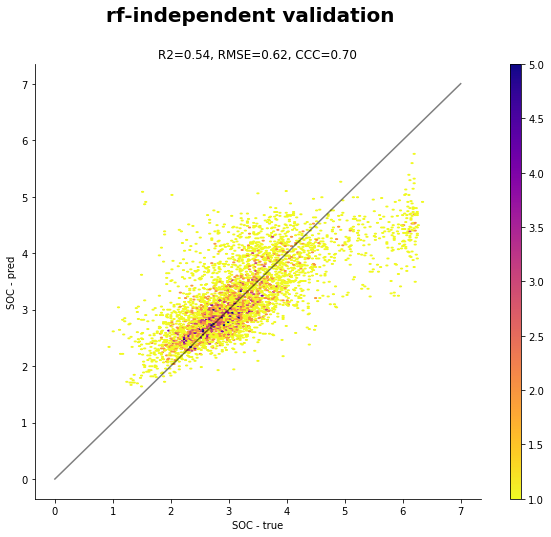

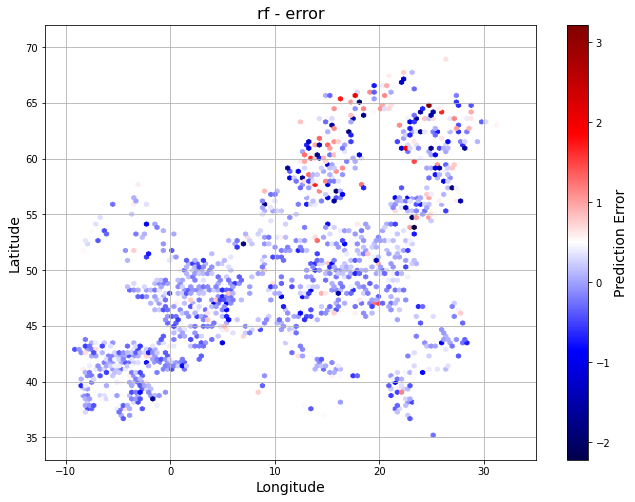

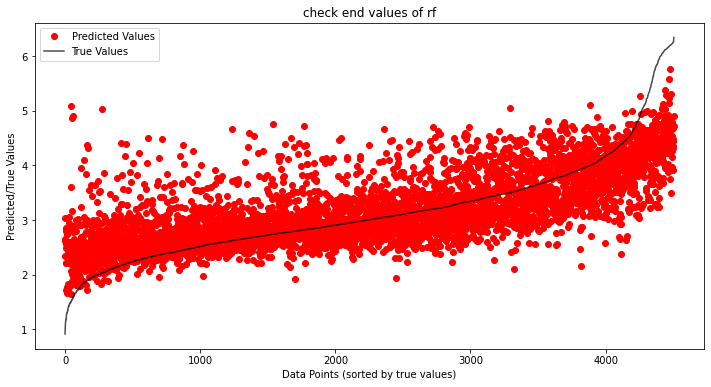

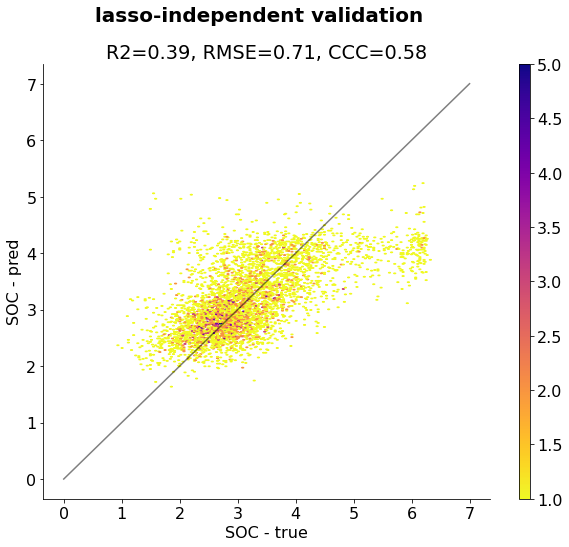

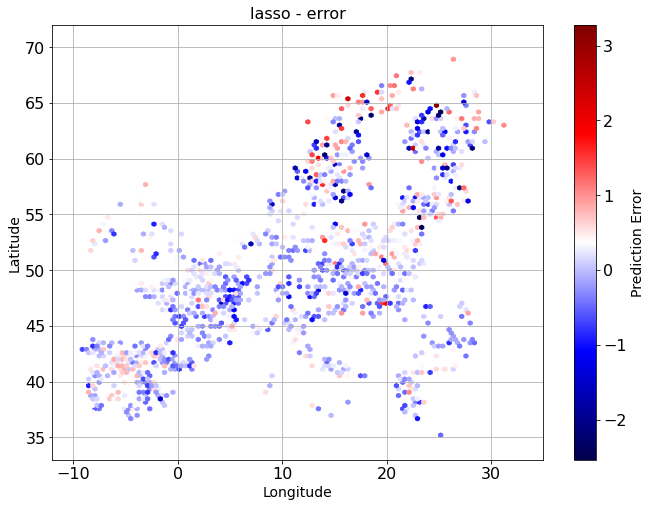

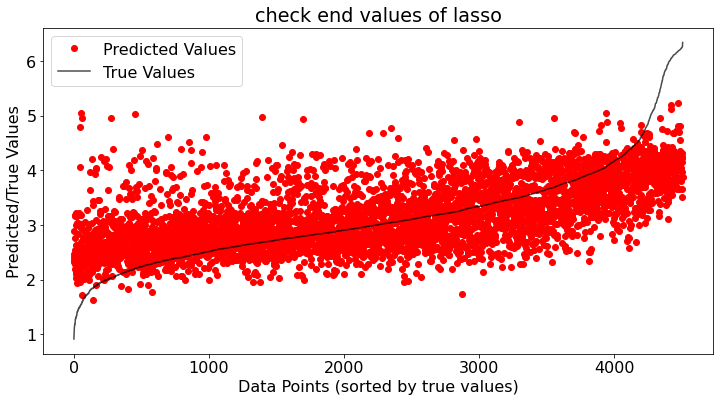

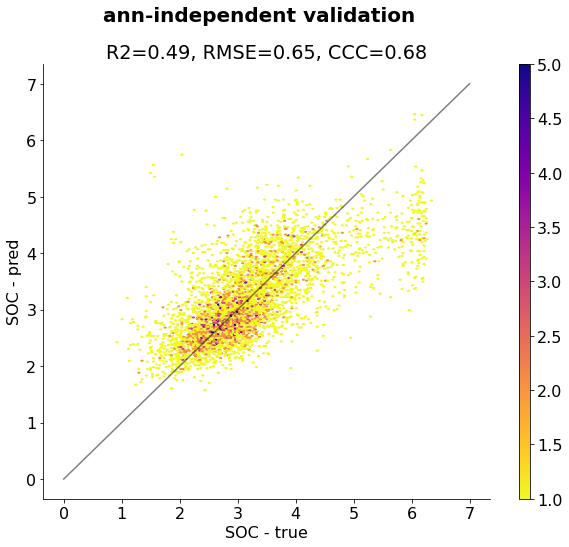

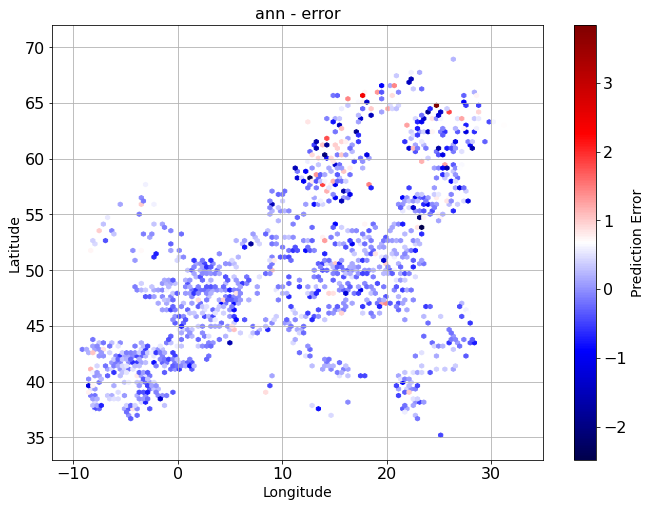

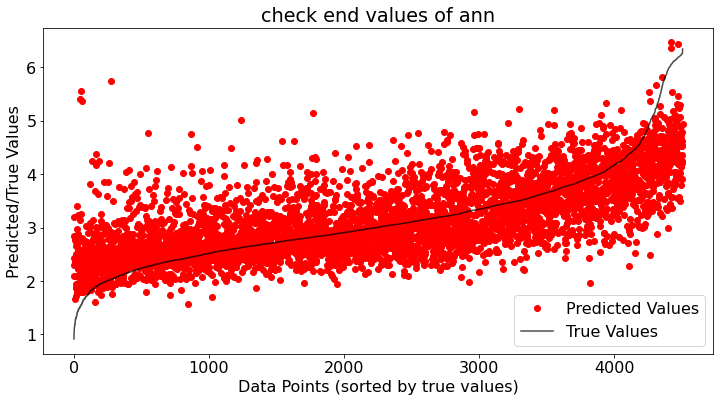

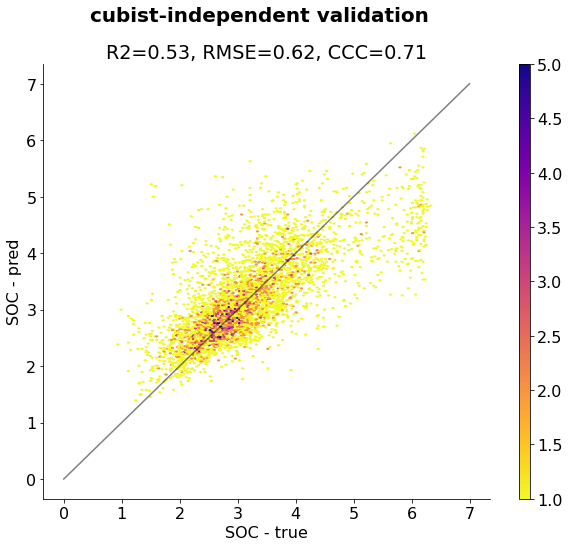

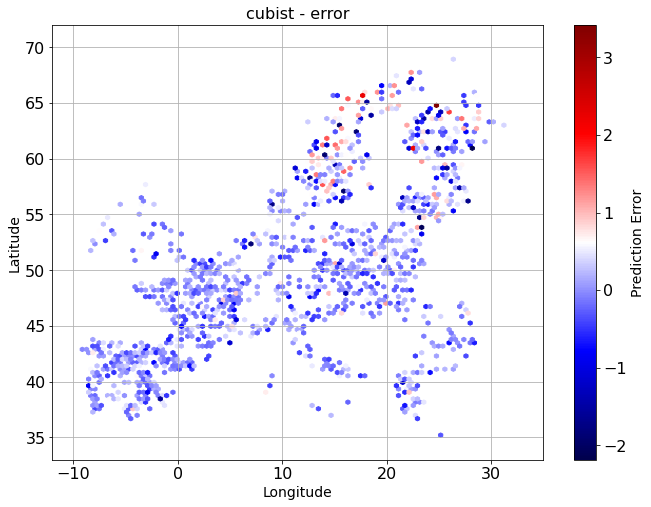

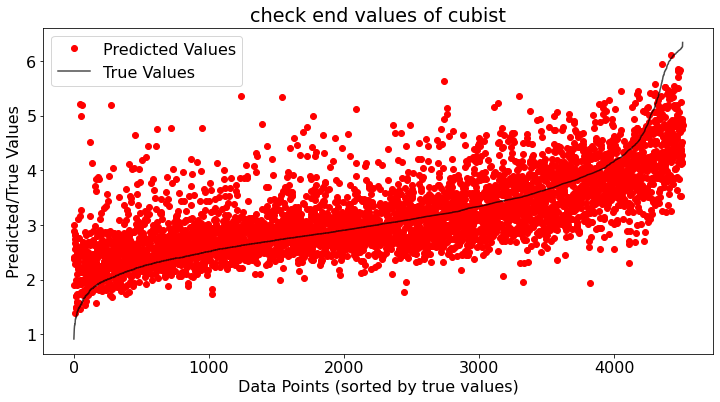

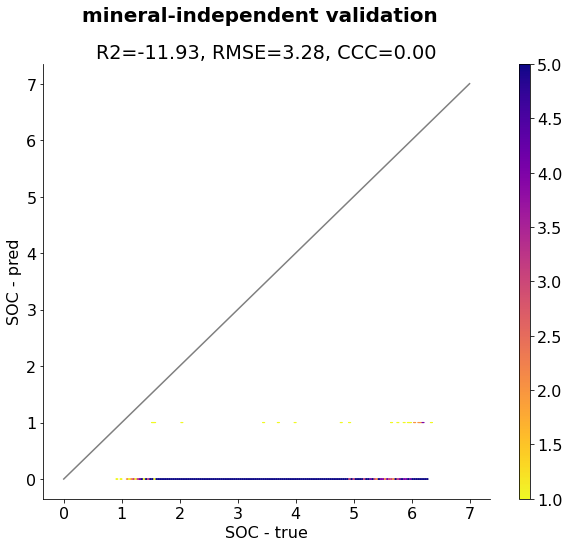

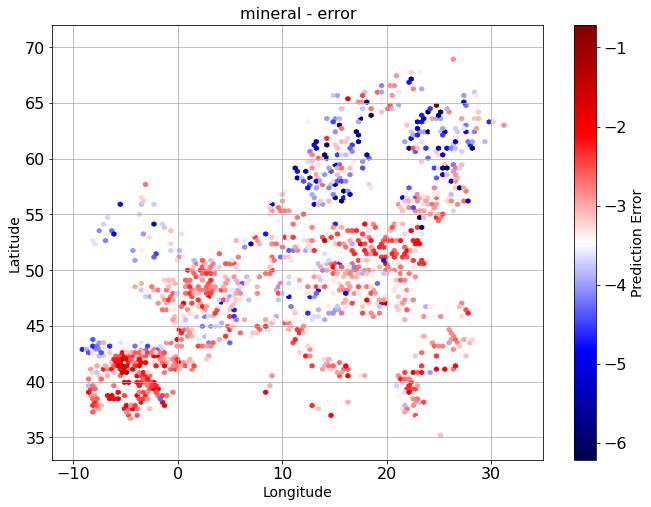

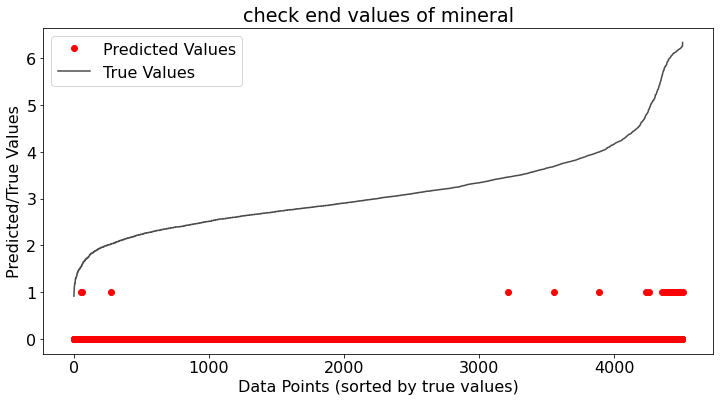

,title,R2_val,RMSE_val,CCC_val
0,rf,0.537632,0.620744,0.695127
1,lasso,0.394103,0.710589,0.577290
2,ann,0.489533,0.652233,0.683045
3,cubist,0.531515,0.624837,0.713484
4,mineral,-11.931688,3.282814,0.001939


In [2]:
# get all the trained models
from tool_kit import error_spatial_plot, sorted_plot
model_list = find_files(f'{folder}/SOC-EU/model/','*model*.joblib')
model_list = [str(i) for i in model_list]

results = []
warnings.filterwarnings("ignore")
for model_path in model_list:
    model_name = model_path.split('_')[-1].split('.')[0]
    model = joblib.load(model_path)

    y_pred_val = model.predict(test[covs])
    r2_val, rmse_val, ccc_val = accuracy_plot(test[tgt], y_pred_val, model_name+ '-independent validation', vmax=5) # visuliazation
    error_spatial_plot(test[tgt], y_pred_val, test['lat'], test['lon'], model_name)
    sorted_plot(test[tgt],y_pred_val,model_name)
    results.append({
        'title': model_name,
        'R2_val': r2_val,
        'RMSE_val': rmse_val,
        'CCC_val': ccc_val
    })
    
results_df = pd.DataFrame(results)
results_df.to_csv(f'{folder}/SOC-EU/model/010_metrics_val.base.model.csv', index=False)
results_df 

### evaluation EML

<Axes: >

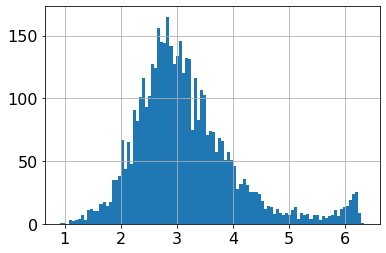

In [5]:
test[tgt].hist(bins=100)

In [ ]:
for model_path in model_list:
    model_name = model_path.split('_')[-1].split('.')[0]
    model = joblib.load(model_path)
    
    group_kfold = GroupKFold(n_splits=5)

    ttprint(f'spatial CV for {model_name}')
    y_pred_cv = cross_val_predict(model, train[covs], train[tgt], cv=group_kfold, groups=train[spatial_cv_column], n_jobs=90)
    ttprint(f'finish spatial cv')
    
    # calculate metrix, and visualize the results
    r2_cv, rmse_cv, ccc_cv = accuracy_plot(train[tgt], y_pred_cv, model_name + '-CV') # visuliazation
    
    if independent_validation == 1:
        ttprint(f'fitting mapie for {model_name}')
        mapie = MapieRegressor(model, method="minmax", cv=5, n_jobs=90) # this cv is to compute the conformal scores, and spatial cross validation
        mapie.fit(train[covs], train[tgt], groups=train[spatial_cv_column])
        ttprint(f'finish fitting mapie')
        y_pred_val, y_pis = mapie.predict(test[covs], alpha=0.1) # 90% prediction interval, 5%-95%
        
        joblib.dump(mapie, f'{folder}/SOC-EU/model/test_mapie_{model_name}.joblib')
        picp, pi_width = uncertainty_plot(test[tgt], y_pred_val, y_pis[:, 0, 0], y_pis[:, 1, 0], model_name) # visualization
        # calculate metrix
        r2_val, rmse_val, ccc_val = accuracy_plot(test[tgt], y_pred, model_name+ '-independent validation') # visuliazation
    else:
        picp = np.nan
        pi_width = np.nan
        r2_val = np.nan
        rmse_val = np.nan
        ccc_val = np.nan

    # Store the results for the current feature set
    results.append({
        'title': model_name,
        'R2_CV': r2_cv,
        'RMSE_CV': rmse_cv,
        'CCC_CV': ccc_cv,
        'R2_val': r2_val,
        'RMSE_val': rmse_val,
        'CCC_val': ccc_val,
        'PICP': picp,
        'PI width': pi_width
    })

In [2]:
# get all the trained models
model_list = find_files(f'{folder}/SOC-EU/model/','*model*')
model_list = [str(i) for i in model_list]

results = []
normal_space = 0
uncertainty = 0

X = train
Y = test

for model_path in model_list:
    model_name = model_path.split('_')[-1].split('.')[0]
    model = joblib.load(model_path)
    
    ttprint(f'start evaluating {model_name} with spatial cross validation')
    if uncertainty ==1:
        mapie = MapieRegressor(model, method="minmax", cv=5, n_jobs=90) # this cv is to compute the conformal scores, and spatial cross validation
        mapie.fit(X[covs], X[tgt], groups=X[spatial_cv_column])
#         y_pred, y_pis = mapie.predict(Y[covs], alpha=0.1) # 90% prediction interval, 5%-95%
        y_pred, y_pis = mapie.predict(X[covs], alpha=0.1)

        joblib.dump(mapie, f'{folder}/SOC-EU/model/test_mapie_{model_name}.joblib')
    else:
        y_pred = cross_val_predict(model, X[covs], X[tgt], cv=5, groups=X[spatial_cv_column], n_jobs=90)
        
    ttprint('finish spatial cross validation')
    

    if normal_space==1:
        tgt = 'oc'
        y_pred = np.expm1(y_pred)
        if uncertainty == 1:
            y_pis = np.expm1(y_pis)
        
    # calculate metrix
    r2, rmse, ccc = accuracy_plot(Y[tgt], y_pred, model_name) # visuliazation
    if uncertainty ==1:
        picp, pi_width = uncertainty_plot(Y[tgt], y_pred, y_pis[:, 0, 0], y_pis[:, 1, 0], model_name) # visualization
    else:
        picp = np.nan, pi_width = np.nan

    # Store the results for the current feature set
    results.append({
        'title': model_name,
        'R2': r2,
        'RMSE': rmse,
        'CCC': ccc,
        'PICP': picp,
        'PI width': pi_width
    })


[10:04:07] start evaluating rf with spatial cross validation


NameError: name 'cross_val_predict' is not defined

### evaluate all the models with individual validation dataset

In [ ]:
# get all the trained models
model_list = find_files(f'{folder}/SOC-EU/model/','*mapie*')
model_list = [str(i) for i in model_list]

results = []
normal_space = 0
uncertainty = 1

X = train
Y = test

for model_path in model_list:
    model_name = model_path.split('_')[-1].split('.')[0]
    model = joblib.load(model_path)
    
    ttprint(f'start evaluating {model_name} with spatial cross validation')
    if uncertainty ==1:
        y_pred, y_pis = mapie.predict(Y[covs], alpha=0.1) # 90% prediction interval, 5%-95%
    else:
        y_pred = cross_val_predict(model, X[covs], X[tgt], cv=5, groups=X[spatial_cv_column], n_jobs=90)
        
    ttprint('finish spatial cross validation')
    
    if normal_space==1:
        tgt = 'oc'
        y_pred = np.expm1(y_pred)
        if uncertainty == 1:
            y_pis = np.expm1(y_pis)
        
    # calculate metrix
    r2, rmse, ccc = accuracy_plot(Y[tgt], y_pred, model_name) # visuliazation
    if uncertainty ==1:
        picp, pi_width = uncertainty_plot(Y[tgt], y_pred, y_pis[:, 0, 0], y_pis[:, 1, 0], model_name) # visualization
    else:
        picp = np.nan, pi_width = np.nan

    # Store the results for the current feature set
    results.append({
        'title': model_name,
        'R2': r2,
        'RMSE': rmse,
        'CCC': ccc,
        'PICP': picp,
        'PI width': pi_width
    })


In [ ]:
### distribution plot